# LAB 1: Metric Algorithms
### AI and Machine Learning // Suchkova Natalia М8О - 114М - 22
17.03.23 @ MAI IT-Center

## The Task
1. Применить метод K ближайших соседей  (KNN ядерный), взвешенный алгоритмом STOLP для пяти классов, сгенерированных с помощью MakeClassification

2. (*) Для сгенерированного датасета, сгенерировать профиль компактности

3. Для сгенерированного датасета, произвести оптимизацию по выбору ширины окна (или метод меняющегося окна)

4. Найти датасет с картинками (2-3 класса) небольшой (100 картинок достаточно, классифицированных). Найти метод\библиотеку для построения embedding (векторизации) изображений. Применить этот метод на картинки. Применить КNN (без оптимизации) для полученного датасета из векторизванных картинок.

5. (*) Задание 4 со своими фотографиями.

## Table of Contents


1. [**Chosen Functions' Formulas**](#g5)


2. [**Functions' Visualization**](#g4)

    - [Himmelblau Function](#g4)
    
    - [Rastrigin Function](#g3)
    
    - [Rosenbrock Function](#g2)


3. [**Classical Gradient Descent**](#g1)

    - [For Himmelblau](#g6)
    
    - [For Rastrigin](#g7)
    
    - [For Rosenbrock](#g8)
    
    
4. [**Classical GD with Data Blobs**](#g10)
    
    - [Loss Function & Data Generation](#g10)


5. [**Сlassical Stochastic Gradient Descent**](#g9)
    
    - [SGD Method Code](#g11)
    
    - [SGD w/ Data Blobs](#g90)
    

## Задание 1.

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors


from scipy.spatial import KDTree

In [175]:
seed = np.random.seed(11)

#### Генерим данные

In [176]:
X, Y = make_classification(n_samples=1000, n_features=3, 
                           n_informative=3, n_classes=5, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=seed)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=seed)

#### KNN

In [177]:
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=6)

In [178]:
predictions = model.predict(X_test)

In [179]:
def plot(data, preds):
    colors = [np.array([1, 0, 0]).reshape(1, -1), 
              np.array([0, 1, 0]).reshape(1, -1), 
              np.array([0, 0, 1]).reshape(1, -1),
              np.array([1, 1, 0]).reshape(1, -1), 
              np.array([1, 0, 1]).reshape(1, -1)
             ] # распределение цветов по классам
    c = [colors[i] for i in preds] # распределение цветов по классам
    fig = plt.figure()
    ax = fig.add_subplot(111, 
                         projection='3d'
                        )
    ax.scatter(data[ : , 0], 
               data[ : , 1], 
               data[ : , 2], 
               c=c) # изображаем классификацию
    plt.show()
    
    
def plot_compare(data, labels, lbl_preds):
    colors = [np.array([1, 0, 0]).reshape(1, -1), 
              np.array([0, 1, 0]).reshape(1, -1), 
              np.array([0, 0, 1]).reshape(1, -1),
              np.array([1, 1, 0]).reshape(1, -1), 
              np.array([1, 0, 1]).reshape(1, -1)
             ]
    
    fig = plt.figure(figsize=plt.figaspect(0.6))
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_title('Реальные значения')
    c = [colors[i] for i in labels]
    ax1.scatter(data[ : , 0], 
               data[ : , 1], 
               data[ : , 2], 
               c=c)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title('Наши предсказания')
    c = [colors[i] for i in lbl_preds]
    ax2.scatter(data[ : , 0], 
               data[ : , 1], 
               data[ : , 2], 
               c=c)
    
    plt.show()
    
    
# def plot(n_samples, data, preds):
#     colors = [np.array([1, 0, 0]).reshape(1,-1), 
#               np.array([0, 1, 0]).reshape(1, -1), 
#               np.array([0, 0, 1]).reshape(1, -1),
#               np.array([1, 1, 0]).reshape(1, -1), 
#               np.array([1, 0, 1]).reshape(1, -1)
#              ] # распределение цветов по классам
#     c = [colors[i] for i in preds[ :n_samples]] # распределение цветов по классам
#     fig = plt.figure()
#     ax = fig.add_subplot(111, 
#                          projection='3d'
#                         )
#     ax.scatter(data[ :n_samples, 0], 
#                data[ :n_samples, 1], 
#                data[ :n_samples, 2], 
#                c=c) # изображаем классификацию
#     plt.show()

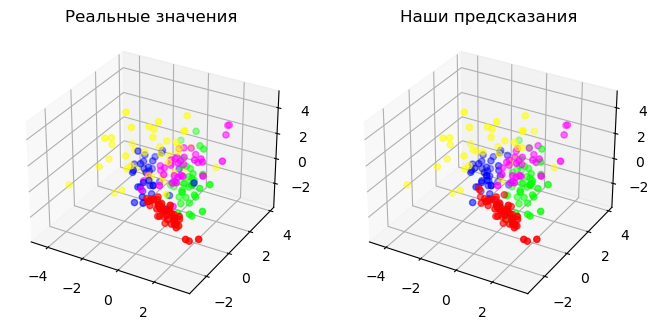

In [180]:
plot_compare(X_test, Y_test, predictions)

In [181]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90        45
           1       0.81      0.85      0.83        41
           2       0.65      0.76      0.70        34
           3       0.86      0.72      0.78        43
           4       0.90      0.73      0.81        37

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.82      0.81      0.81       200



#### STOLP  
— алгоритм отбора эталонных объектов для метрического классификатора.

Пусть дана обучающая выборка $X^l=(x_i, y_i)_{i=1}^l$, где $x_i$ — объекты, $y_i=y^*(x_i)$ — классы, которым принадлежат эти объекты. 

Кроме того, задана метрика $\rho \: X \times X \rightarrow \mathbb{R}$, такая, что выполняется гипотеза компактности. 

При классификации объектов метрическим классификатором $$a(u, X^l) = \mathrm{arg}\max_{y\in Y} \Gamma_y (u, X^l) = \mathrm{arg}\max_{y\in Y} \sum_{i=1}^l[y_u^(i)=y]w(i, u),$$ например, `методом ближайших соседей` необходимо вычислять расстояния от классифицируемого объекта до всех объектов обучающей выборки. 

Минусы: Время, затрачиваемое на это для каждого классифицируемого объекта, пропорционально размеру обучающей выборки. Кроме того, оказывается необходимым хранить большой объем данных.

Но не все объекты обучающей выборки равноценны. 

Среди них есть
- наиболее типичные представители классов, то есть **эталоны**; 
- **неинформативные объекты**, при удалении которых из обучающей выборки качество классификации не изменится;
- **выбросы, или шумовые объекты** — объекты, находящиеся в гуще «чужого» класса, только ухудшающие качество классификации.

Поэтому необходимо уменьшить объем обучающей выборки, оставив в ней только эталонные объекты для каждого класса.

**Oтступ (margin)** показывает насколько истинный класс далеко от другого класса. Отступ объекта показывает нам, насколько глубоко текущий объект лежит в пределах своего класса. Например, если почти все ближайшие соседи некоторого объекта x_i принадлежат к тому же классу, что и сам x_i, мы можем сказать, что у него очень положительный отступ. С другой стороны, если почти все ближайшие соседи принадлежат к другому классу, чем x_i, отступ должен быть отрицательным. Мы можем вычислить маржу таким образом: в случае, если отступ положительный, то предсказание является верным. В случае, если отступ отрицательный, то предсказание является ошибочным.

Но для начала нужно сделать несколько шагов:

1. Для каждого элемента выборки найти сумму евклидового расстояния до ближайших n соседей;

2. Отсортировать элементы выборки по сумме расстояний;

3. Взять первые N элементов - они и будут эталонными объектами.

https://jet1black.wordpress.com/2015/10/03/stolp-algorithm-implementation/

In [182]:
def compute_margins(xkd, x, y, u, u_ans, n):
    result = []
    bound = min(n, y.shape[0]) # задаем количество ближайших соседей для исследования
    
    for cur_u_idx, cur_u_coord in enumerate(u):  # задаем индекс каждой точке в u
        idx = xkd.query(cur_u_coord, bound)[1]  # сохраняем индексы ближайших соседей
        maj = {}
        
        for i in idx:
            y_cur = y[i]  # перебираем все класс в ближайших соседях по их индексу
            di = np.linalg.norm(cur_u_coord - x[i])  # расстояние от текущей точки до каждой точки в данных
            dn = np.linalg.norm(cur_u_coord - x[idx[bound - 1]])  # расстояние от текущей точки до предыдущей из n соседей
            w = 0.0
            
            if di != 0.0 and dn > di:
                w = dn / di
                
            maj[y_cur] = maj.get(y_cur, 0) + w  # обновляем в словаре по индексу точки ее вес, 
                                                # если новая точка, то ее вес 0 сначала
            
        cur_u_ans = u_ans[cur_u_idx] # находим в Y_train по текущему индексу класс [u_ans[cur_u_idx]][0]
        correct_score = maj.get(cur_u_ans, 0)  # достаем из словаря вес точки
        del maj[cur_u_ans]
        
        max_wrong = 0
        if len(maj) > 0:
            max_wrong = sorted(maj.items(), key=lambda x: x[1])[-1][1] # находим максимально отдаленный элемент (точку)
            
        result.append(correct_score - max_wrong)  # для рассчета конечной удаленности вычитаем самый большой отступ
        
    return np.array(result)

In [183]:
# def compute_margins(xkd, x, y, u, u_ans, n):  мы считаем отступ для всех точек, поэтому у нас х и и это одно и то же
margins = compute_margins(KDTree(X_test), X_test, Y_test, X_test, Y_test, 5)

In [184]:
len(margins)

200

In [185]:
def stolp(src_x, src_y, err_num, depth_limit, n):
    #Step 2
    support_x = []
    support_y = []
    src_xkd = KDTree(src_x)
    margins = np.array([compute_margins(src_xkd, src_x, src_y, src_x, src_y, n)]).transpose()
    #Step 3
    x = src_x[margins[:, 0] > depth_limit]
    y = src_y[margins[:, 0] > depth_limit]
    margins = margins[margins[:, 0] > depth_limit]
    sorted_margs = np.argsort(margins[:, 0])
    #Step 4
    print(len(x), len(y), np.unique(y), len(sorted_margs))
    for ans in np.unique(y):
        for m in sorted_margs:
            print(y[m], m, ans)
            if y[m] == ans:
                print(x[m], y[m])
                support_x.append(x[m])
                support_y.append(y[m])
                x = np.delete(x, (m), axis=0)
                y = np.delete(y, (m), axis=0)
                break
    errors = x.shape[0]
    
    #Step 5
    while errors > err_num:
        xkd = KDTree(np.array(support_x))
        margins = compute_margins(xkd, np.array(support_x), np.array(support_y), x, y, n)
        KNN_preds = model.predict(support_x)
#         errors = sum(KNN_preds != src_y)
        errors = len(KNN_preds[KNN_preds == src_y[:len(KNN_preds)]])
        sorted_margs = np.argsort(margins)  # выводим индексы отсортированных отступов
        to_delete = []
        min = sorted_margs[0]
        support_x.append(x[min])
        support_y.append(y[min])
        to_delete.append(min)
        
        x = np.delete(x, to_delete, axis=0)
        y = np.delete(y, to_delete, axis=0)
    return np.array(support_x), np.array(support_y)


In [186]:
stolp_prx, stolp_pry = stolp(X_test, Y_test, 3, 1, 5)

135 135 [0 1 2 3 4] 135
4 26 0
4 68 0
0 94 0
[-0.02473452  0.11620545 -1.84968998] 0
4 26 1
4 68 1
0 94 1
0 12 1
0 114 1
3 123 1
3 131 1
1 66 1
[2.61295931 0.30737563 0.65311644] 1
4 26 2
3 68 2
1 94 2
0 12 2
0 114 2
1 123 2
1 131 2
4 66 2
4 24 2
0 49 2
2 62 2
[-1.15456666 -0.06948743 -0.7827143 ] 2
4 26 3
4 68 3
4 94 3
0 12 3
2 114 3
0 123 3
3 131 3
[-1.44369004 -0.2167594   0.89295674] 3
4 26 4
[-0.21404384  0.78465844  0.43481987] 4


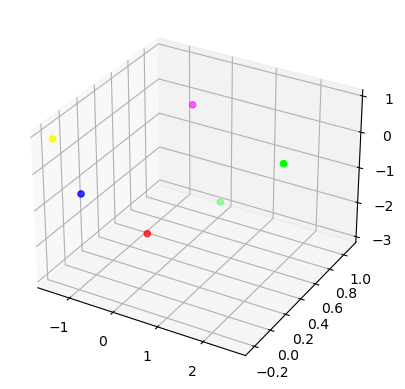

In [187]:
plot(stolp_prx, stolp_pry)

#### Parzen Window Method

In [ ]:
def ParzRos_score(x: float, h: float, data: np.array, kernel: Mapping, distance: Mapping) -> float:
    """
    Function: 
        Метод возвращает значение, найденное методом Парзена-Розенблатта для группы точек.

    Args: 
        x: float - параметр функции ядра.
        h: float - параметр метода Парзена-Розенблатта: ширина окна.
        data: list или array - набор точек.
        kernel: Mapping - тип ядра.
        distance: Mapping - функция расчета расстояния между двумя точками 
                        на плоскости или в пространстве (для нелинейной задачи).

    Return:
        Значение найденное методом Парзена-Розенблатта для группы точек (float).
    """
    return sum([kernel(distance(x, point) / h) for point in data]) / (len(data) * h)